In [1]:
import merg_rates3 as merg_rates
import my_sham_hack3 as sham
import numpy as np
import pandas as pd
import random
import scipy

from progressbar import ProgressBar
from itertools import cycle, islice

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from matplotlib.lines import Line2D
from cycler import cycler
%matplotlib inline

rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif' 
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.grid']=True
rcParams['axes.titlesize']=24
rcParams['axes.labelsize']=20
rcParams['axes.titlepad']=15
rcParams['legend.frameon'] = True
rcParams['legend.facecolor']='white'
rcParams['legend.fontsize']=18

In [3]:
htpm=merg_rates.HalTreepmClass()

# in merg_rates3.HalTreepm():
  read /data1/arwetzel/lcdm250/snapshot.txt
  read  5177765 subhalo from subhalo_tree_00.dat
  read  5407196 subhalo from subhalo_tree_01.dat
  read  5485481 subhalo from subhalo_tree_02.dat
  read  5517336 subhalo from subhalo_tree_03.dat
  read  5548084 subhalo from subhalo_tree_04.dat
  read  5583078 subhalo from subhalo_tree_05.dat
  read  5615345 subhalo from subhalo_tree_06.dat
  read  5650410 subhalo from subhalo_tree_07.dat
  read  5682696 subhalo from subhalo_tree_08.dat
  read  5715688 subhalo from subhalo_tree_09.dat
  read  5748795 subhalo from subhalo_tree_10.dat
  read  5779167 subhalo from subhalo_tree_11.dat
  read  5805949 subhalo from subhalo_tree_12.dat
  read  5824060 subhalo from subhalo_tree_13.dat
  read  5837797 subhalo from subhalo_tree_14.dat
  read  5841491 subhalo from subhalo_tree_15.dat
  read  5836226 subhalo from subhalo_tree_16.dat
  read  5823060 subhalo from subhalo_tree_17.dat
  read  5795900 subhalo from subhalo_tree_18

/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


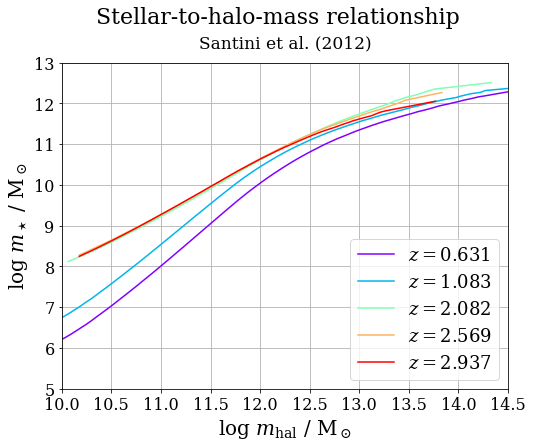

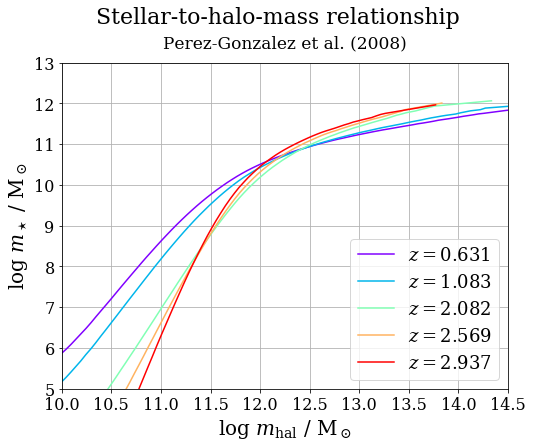

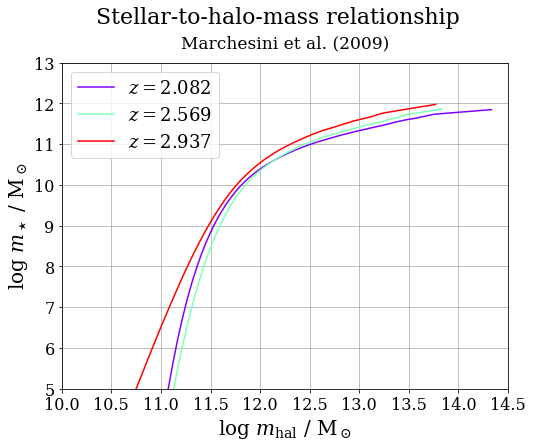

In [4]:
def plt_shmr_zis(source,zis,title):
    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111)
    colors = mpl.cm.rainbow(np.linspace(0, 1, len(zis)))
    for zi,c in zip(zis,colors):
        all_ms_hal=htpm.subcat[zi][htpm.smtype]
        ms_hal=np.linspace(all_ms_hal.min(),all_ms_hal.max(),300)
        z=htpm.subcat[zi].snap['z']
        ms_gal=htpm.shmr_avg(ms_hal=ms_hal,zi=zi,source=source,
                             scat=0.,mmin=3.)
        isnan=np.isnan(ms_hal) | np.isnan(ms_gal)
        ax.plot(ms_hal[~isnan],ms_gal[~isnan],'-',
                label='$z={0:0.3f}$'.format(z),color=c)
    ax.set_ylim(8,1)    
    
    plt.suptitle('Stellar-to-halo-mass relationship',y=1.01,
                 size=22)
    ax.set_title(title,size=17)    
    ax.set_xlabel('log $m_\mathrm{hal}$ / M$_\odot$')
    ax.set_ylabel('log $m_\star$ / M$_\odot$')
    ax.set_xlim(10,14.5)
    ax.set_ylim(5,13)
    ax.legend()
    plt.show()

zis_plt=[10,15,23,26,28]
plt_shmr_zis('santini',zis_plt,'Santini et al. (2012)')
plt_shmr_zis('perez',zis_plt,'Perez-Gonzalez et al. (2008)')
zis_plt=[23,26,28]
plt_shmr_zis('march',zis_plt,'Marchesini et al. (2009)')

In [5]:
def get_rng(nam,z):
    if (nam=='muzzin-bestslope')|(nam=='muzzin-sameslope'):
        nam='muzzin'
    mnam=nam+'_m'
    nnam=nam+'_dndlogm'
    rngs=pd.read_csv('/home/users/staudt/projects/mergers/data/smf_ranges.csv')
    zs_lo=rngs['z_low']
    zs_hi=rngs['z_hi']
    if z in list(zs_lo)+list(zs_hi):
        inz=(z==zs_lo)|(z==zs_hi)|((zs_lo<z) & (zs_hi>z))
    else:
        inz=(zs_lo<z) & (zs_hi>z)
    
    try:
        if nam in ['fontana','duncan','baldry']:
            rng_ms=[]
            rng_dndlogms=[]
            for mod in ['_comp_','_inc_']:
                mnam=nam+mod+'m'
                nnam=nam+mod+'dndlogm'
                rng_ms.append(list(rngs[mnam][inz]))
                rng_dndlogms.append(list(rngs[nnam][inz]))
            rng_ms=np.array(rng_ms)
            rng_dndlogms=10.**np.array(rng_dndlogms)
            if rng_ms.shape[-1]==0:
                rng_ms=np.array([[0.1,17.],
                                 [0.1,17.]])
                rng_dndlogms=np.ones((2,2))*np.nan
        else:
            rng_ms=np.array(rngs[mnam][inz])
            rng_dndlogms=np.array(rngs[nnam][inz])
            isnan=np.isnan(rng_ms)
            rng_ms=rng_ms[~isnan]
            rng_dndlogms=10.**rng_dndlogms[~isnan]
    except KeyError:
        rng_ms=np.array([0.1,17.])
        rng_dndlogms=None
    if len(rng_ms)==0:
        rng_ms=np.array([0.1,17.])
        rng_dndlogms=None
    return np.array([rng_ms,rng_dndlogms])

def plt_shmr(ax,source,
             zi,scat,mmin,compl_dashes=[1,0],**kwargs):
    z=htpm.subcat[zi].snap['z']
    ms_hal_all=htpm.subcat[zi][htpm.smtype]
    ms_hal=np.linspace(ms_hal_all.min(),ms_hal_all.max(),500)
    mn_rngs=get_rng(source,z)
    ms_gal = htpm.shmr_avg(ms_hal=ms_hal,zi=zi,source=source,scat=scat,mmin=mmin,
                           Mwid=0.05)
    if source in ['fontana','duncan','baldry']:
        Nrngs=mn_rngs.shape[1]
        ms_fit=np.array([mn_rngs[0][irng] for irng in np.arange(Nrngs)])
        m_min=np.nanmin(ms_fit,1)
        is_compl=ms_gal>=m_min[0]
        is_inc=(ms_gal<m_min[0])&(ms_gal>=m_min[1])
        is_extrap=ms_gal<m_min[1]
    else:
        ms_fit=mn_rngs[0]
        m_min=ms_fit.min()
        is_extrap=ms_gal<m_min
        is_compl=~is_extrap
        is_inc=np.repeat(False,len(ms_gal))
    not_nan=~np.isnan(ms_gal)
    is_compl*=not_nan
    is_inc*=not_nan
    is_extrap*=not_nan
    ms_compl=ms_gal[is_compl]
    ms_inc=ms_gal[is_inc]
    ms_extrap=ms_gal[is_extrap]
    ms_hal_compl=ms_hal[is_compl]
    ms_hal_inc=ms_hal[is_inc]
    ms_hal_extrap=ms_hal[is_extrap]
    
    ax.plot(ms_hal_extrap,ms_extrap,dashes=[1,4],**kwargs)
    ax.plot(ms_hal_inc,ms_inc,dashes=[4,3],**kwargs)
    ax.plot(ms_hal_compl,ms_compl,dashes=compl_dashes,**kwargs)
    return None

def plt_allshmrs(ax,zi,scat,mmin):
    z=htpm.subcat[zi].snap['z']
    
    ms=np.linspace(6,15,500)    
    sources=['cole','li','baldry','drory','mous',
             'perez','muzzin-bestslope',
             'march','fontana','santini','caputi','duncan',
             'lee']
    labels=['Cole et al. (2001)','Li & White (2009)',
            'Baldry et al. (2008)','Drory et al. (2009)',
            'Moustakas et al. (2013)',
            'Perez-Gonzalez et al. (2008)','Muzzin et al. (2013)',
            'Marchesini et al. (2009)','Fontana et al. (2006)',
            'Santini et al. (2012)','Caputi et al. (2011)',
            'Duncan et al. (2014)','Lee et al. (2012)']
    
    #Getting the default colors:
    prop_cycle = plt.rcParams['axes.prop_cycle']
    cols = np.array(prop_cycle.by_key()['color'])
    
    #Switching out some of the default colors that don't work well:
    cols[0]='b'
    cols[4]='#7f0eff'
    cols[5]='k'
    #Adding more colors:
    cols=np.append(cols,['#00ff00','#ff00a5'])
    
    #Cycling through the indices of the colors array so I can give
    #each SMF a color
    col_is=np.array(list(islice(cycle(np.arange(len(cols))),
                                None,
                                len(sources))))
    
    #Indices for the color indices array. I'm generating this to
    #serve the joint purpose of randomizing the color assignment
    #(until I find a combination that looks best) and being able
    #to tell when I've gone through the default color list once,
    #at which point I probably should change the line style.
    
    ##Using the same random seed as when I generated the SMF panel plot
    ##doesn't seem to put the colors in the same order, so I'm commenting
    ##the following and just manually entering the col_iis that I
    ##generated for that panel plot.
    #col_iis=np.arange(len(col_is))
    #Using a seed so I get the same color assignments for each z
    #random.seed(2)
    #random.shuffle(col_iis)
    
    ##Entering the col_iis manually:
    col_iis=np.array([6,9,8,2,3,1,4,5,7,10,0,11,12])
    
    #Change the line style once the code has gone through the
    #default color list once
    isdashed=col_iis>len(cols)-1
    
    for i,(source,col_ii) in enumerate(zip(sources,col_iis)):
        try:
            #The easiest way to test whether the SMF is valid at a given
            #redshift is to make an SMFClass instance and see if it works.
            #I don't use the instance again after this, though.
            smf=sham.SMFClass(source,z)
        #except Z_RangeError:
        except ValueError:
            #print('{0} invalid at {1:0.1f}'.format(source,z))
            continue 
        #Change the line style if I've gone through the default
        #colors once:
        if isdashed[i]:
            dashes=[7,1]
        else:
            dashes=[1,0]
        plt_shmr(ax,source,
                 zi,scat,mmin,compl_dashes=dashes,color=cols[col_is[col_ii]])
    return labels,cols[col_is[col_iis]],isdashed

In [6]:
def mak_shmr_panels(scat,mmin=4.):
    fig,axs=plt.subplots(3,3,figsize=(15,15),sharex=True,sharey=True)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)

    pbar=ProgressBar()
    #for axi,z in enumerate([0.1,0.48,1.,2.09,2.57,3.13,4.28]):
    for axi,zi in enumerate([2,8,14,23,26,29,34]):
        labs,lab_cols,isdashed=plt_allshmrs(axs[axi],zi,scat,mmin)
        z=htpm.subcat[zi].snap['z']
        axs[axi].text(0.1,0.9,'$z=${0:0.2f}'.format(z),
                transform=axs[axi].transAxes,
                fontsize=18,ha='left')
        #axs[axi].legend(ncol=2,fontsize=16)

    axs[axi].set_xlim(10,14.5)
    axs[0].set_ylim(6.5,None)
    #axs[0].set_yscale('log')

    for axi in [0,3,6]:
        axs[axi].set_ylabel('log $m_\star\,/\,\mathrm{M}_\odot$')
    for axi in [6,7,8]:
        axs[axi].set_xlabel('log $m_\mathrm{hal}\,/\,\mathrm{M}_\odot$')

    dashess=np.repeat([[1,0]],len(labs),axis=0)
    dashess[np.where(isdashed)[0]]=[3,1]
    cust_lines=[Line2D([0],[0],dashes=list(d),color=col,lw=2) 
                for col,d in zip(lab_cols,dashess)]
    axs[8].legend(cust_lines,labs,ncol=2,fontsize=15)
    plt.suptitle('$\sigma={0:0.2f}$'.format(scat),size=21,y=0.91)

    plt.show()

/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less
/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater_equal
/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less
/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater_equal
/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less


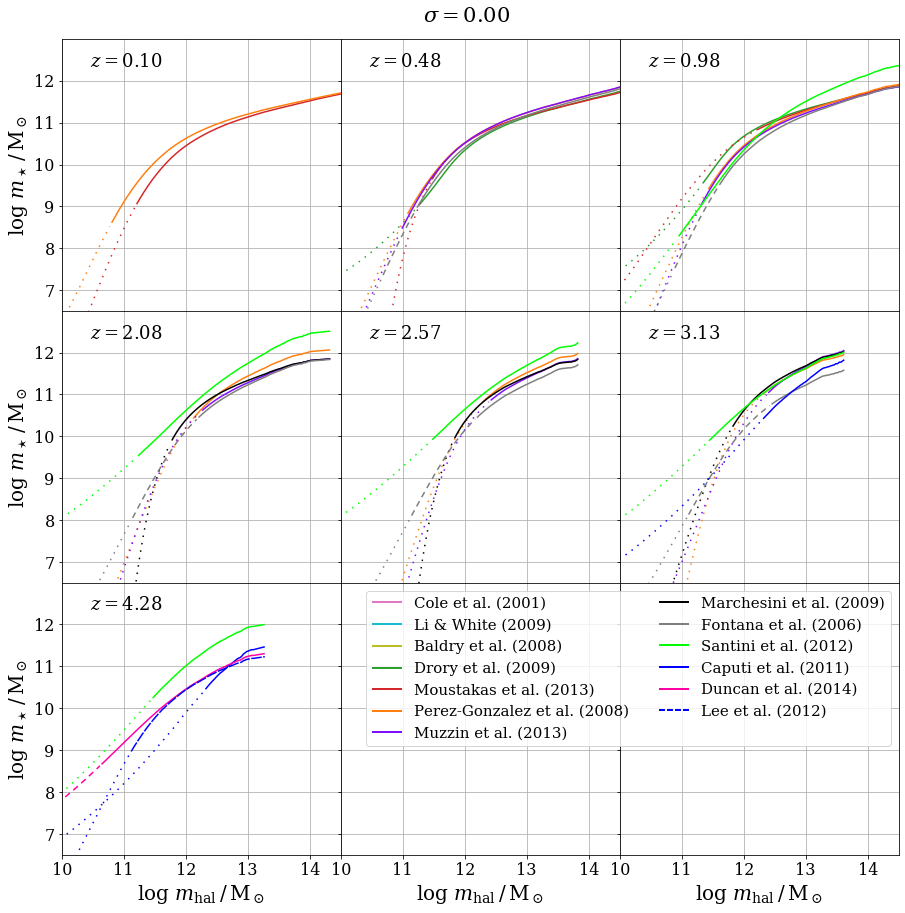

In [7]:
mak_shmr_panels(0.,mmin=3.)

/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less
/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater_equal
/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less
/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater_equal
/home/users/staudt/envs/mergerspython36env/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in less


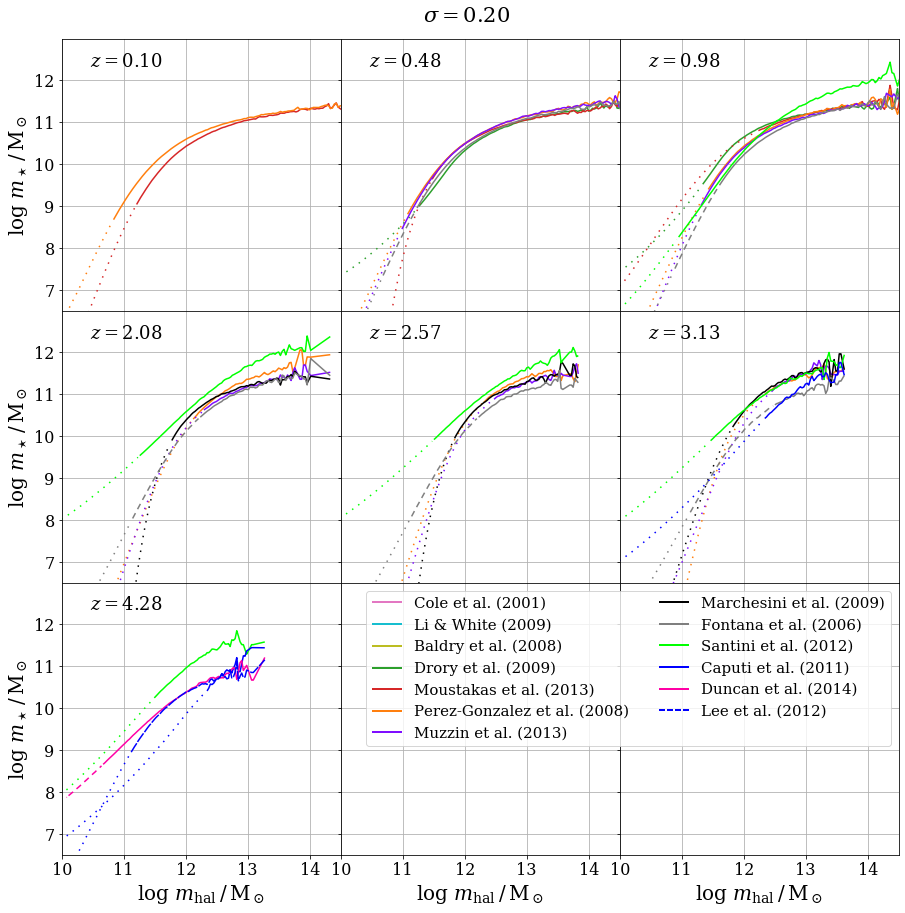

In [8]:
mak_shmr_panels(0.2,mmin=3.)

# The SHAM-based method does not match the right halo masses to galaxies

/home/users/staudt/projects/mergers/mergers3/merg_rates3.py:729: RuntimeWarning: divide by zero encountered in log10
  numdens_gal=np.log10(numdens_gal)
/home/users/staudt/projects/mergers/mergers3/merg_rates3.py:730: RuntimeWarning: divide by zero encountered in log10
  numdens_hal=np.log10(numdens_hal)
/home/users/staudt/projects/mergers/mergers3/staudt_utils3.py:38: RuntimeWarning: invalid value encountered in double_scalars
  upperdiff=np.abs(upperlookuparval-lookupval)
/home/users/staudt/projects/mergers/mergers3/staudt_utils3.py:39: RuntimeWarning: invalid value encountered in double_scalars
  lowerdiff=np.abs(lookupval-lowerlookuparval)


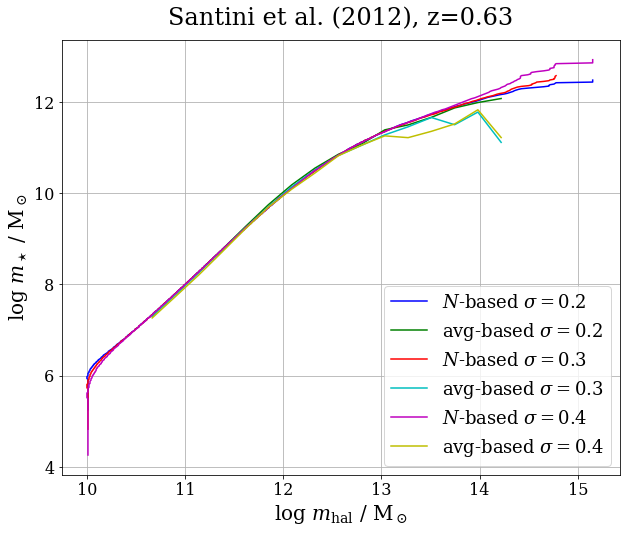

In [9]:
zi=10
source='santini'
scats=[0.2,0.3,0.4]
mmins=[3.,4.,4.5]
ms_hal_all=htpm.subcat[zi][htpm.smtype]
ms_hal=np.linspace(ms_hal_all.min(),ms_hal_all.max(),65)

#saving the original in case I need it later
prop_cycle_orig=rcParams['axes.prop_cycle']
rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)

for scat,mmin in zip(scats,mmins):
    shmr_dat_sham=htpm.shmr_sham(zi=zi,source=source,scat=scat,mmin=mmin)
    shmr_dat_avg=htpm.shmr_avg(ms_hal=ms_hal,zi=zi,source=source,
                          scat=scat,mmin=mmin,Mwid=0.002)
    ax.plot(shmr_dat_sham[0],shmr_dat_sham[1],
            label='$N$-based $\sigma=${0:0.1f}'.format(scat))
    ax.plot(ms_hal,shmr_dat_avg,
            label='avg-based $\sigma=${0:0.1f}'.format(scat))
ax.set_title('Santini et al. (2012), z={0:0.2f}'.format(htpm.subcat[zi].snap['z']))
ax.set_ylabel('log $m_\star$ / M$_\odot$')
ax.set_xlabel('log $m_\mathrm{hal}$ / M$_\odot$')
plt.legend()
plt.show()

## Checking the number densities

### $\displaystyle\frac{dn}{d\log m}$

In [10]:
def dndm_plt(zi,source):
    z=htpm.subcat[zi].snap['z']
    smf_obj=sham.SMFClass(source=source,redshift=z,scat=0.,mmin=3.)    
    ms=np.linspace(3,12.5,70)
    dndm_smf=smf_obj.dndm(ms)

    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111)
    
    ax.plot(ms,dndm_smf,label='theoretical input')
    for scat,mmin in zip([0.,0.2,0.3,0.4,0.6],[3.,3.,3.5,4.,5.]):
        gtpm=merg_rates.GalTreepmClass(haltpm=htpm,scat=scat,
                                       source=source,
                                       shamzibeg=zi,shamziend=zi,
                                       mmin=mmin,conscat=False)
        dndm_tpm=htpm.dndm(snap=zi,galtpm=gtpm,paramed=False)
        ax.plot(dndm_tpm[0],dndm_tpm[1],'d',ms=5,label='$\sigma={0:0.1f}$'.format(scat))    
    ax.set_ylabel('$\\frac{dn}{d\log m}$ / [Mpc$^{-3}\cdot$dex$^{-1}$]')
    ax.set_xlabel('log $m_\star$ / M$_\odot$')
    ax.set_yscale('log')
    ax.set_ylim(1e-6,None)
    ax.legend(fontsize=15)
    ax.text(0.42,0.95,'$z=${0:0.3f}\n{1}'.format(z,source),
            transform=ax.transAxes,ha='center',va='top',fontsize=18)
    plt.show()
    
    return None

running SHAM
running SHAM
running SHAM
running SHAM
running SHAM


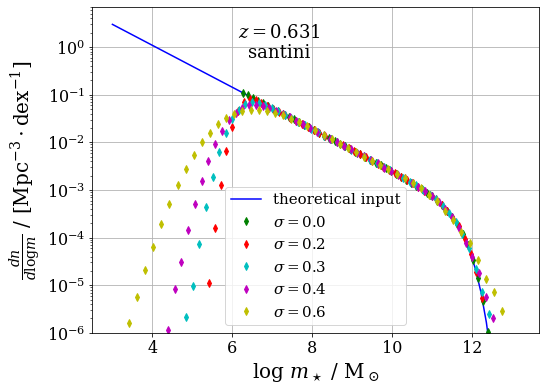

running SHAM
running SHAM
running SHAM
running SHAM
running SHAM


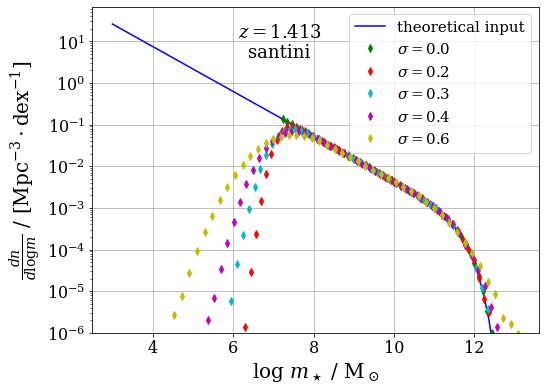

running SHAM
running SHAM
running SHAM
running SHAM
running SHAM


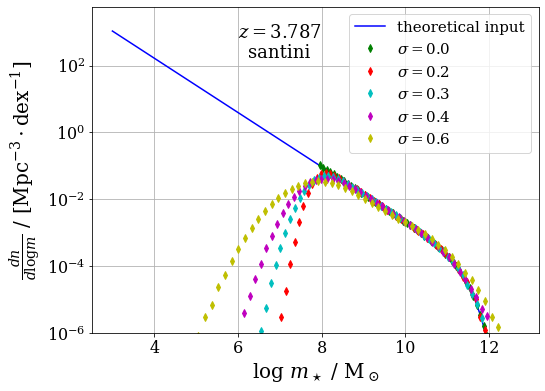

running SHAM
running SHAM
running SHAM
running SHAM
running SHAM


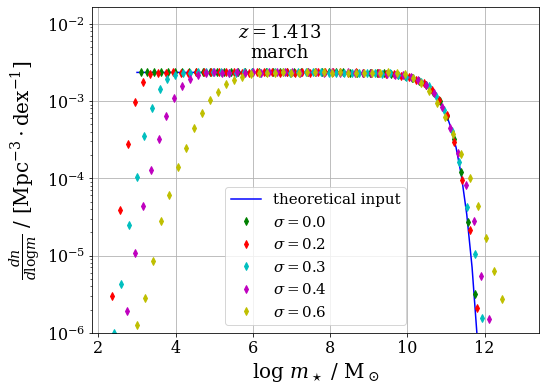

running SHAM
running SHAM
running SHAM
running SHAM
running SHAM


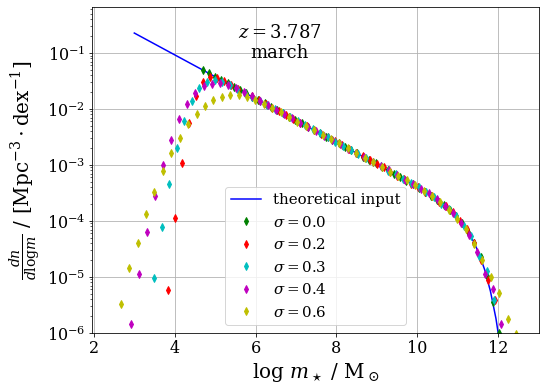

In [11]:
dndm_plt(10,'santini')
dndm_plt(18,'santini')
dndm_plt(32,'santini')
dndm_plt(18,'march')
dndm_plt(32,'march')

$\displaystyle\frac{dn}{d\log m}$ match.

### $n(\geq m)$

In [12]:
def numdens_f(typ,zi,galtpm=None):
    #cumulative number densities i.e. n(>m)
    
    ms,dndms=htpm.dndm(snap=zi,typ=typ,paramed=False,galtpm=galtpm)
    
    #Put dndms in ascending order:
    ms=ms[::-1]
    dndms=dndms[::-1]

    #Need a negative sign because masses are now in descending order
    numdens=-scipy.integrate.cumtrapz(dndms,ms,initial=0)
    
    return ms,numdens

running SHAM
running SHAM
running SHAM


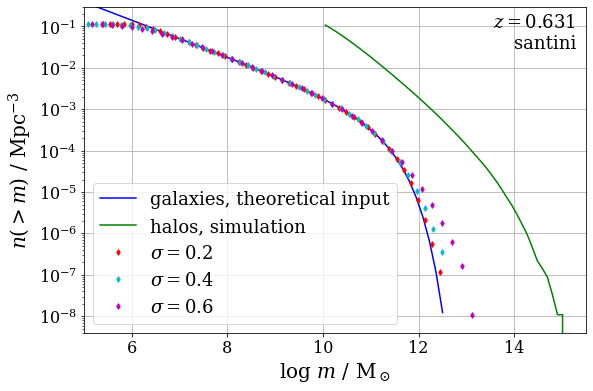

In [13]:
zi=10
z=htpm.subcat[zi].snap['z']
source='santini'
smf_obj=sham.SMFClass(source=source,redshift=z,scat=0.,mmin=3.)  
ms_gal_smf=np.linspace(3,12.5,70)
numdens_gal_smf=[smf_obj.numden(m_gal) for m_gal in ms_gal_smf]
ms_hal,numdens_hal=numdens_f(typ='hal',zi=zi,galtpm=None)

fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(111)
ax.plot(ms_gal_smf,numdens_gal_smf,'-',label="galaxies, theoretical input")
ax.plot(ms_hal,numdens_hal,'-',label="halos, simulation")
for scat,mmin in zip([0.2,0.4,0.6],[3.,3.5,4.]):    
    gtpm=merg_rates.GalTreepmClass(haltpm=htpm,scat=scat,
                                   source=source,
                                   shamzibeg=zi,shamziend=zi,
                                   mmin=mmin,conscat=False)
    ms_gal_tpm,numdens_gal_tpm=numdens_f(typ='gal',zi=zi,galtpm=gtpm)
    ax.plot(ms_gal_tpm,numdens_gal_tpm,'d',ms=4,label="$\sigma={0:0.1f}$".format(scat))
ax.set_yscale('log')
ax.set_xlim(5,15.5)
ax.set_ylim(4e-9,3e-1)
ax.set_ylabel('$n(>m)$ / Mpc$^{-3}$')
ax.set_xlabel('log $m$ / M$_\odot$')
ax.text(0.98,0.98,'$z=${0:0.3f}\n{1}'.format(z,source),
        transform=ax.transAxes,ha='right',va='top',fontsize=18)
ax.legend()
plt.show()

$n(>m)$ match.